In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
import random

In [266]:
def crop_fold(X_train,Y_train,Nfold=5):
    length = X_train.shape[0]
    fold_index = []
    X_train_fold = []
    X_val_fold = []
    for i in range(Nfold):
        fold_index.append(int(length*i/Nfold))
    fold_index.append(length)
    
    for j in range(Nfold):    
        temp_X = []
        temp_Y = []
        for i in range(Nfold):
            if i == j :
                temp_X_val = X_train[fold_index[i]:fold_index[i+1]]
                temp_Y_val = Y_train[fold_index[i]:fold_index[i+1]]
            else:
                temp_X.append( X_train[fold_index[i]:fold_index[i+1]] )
                temp_Y.append( Y_train[fold_index[i]:fold_index[i+1]] )
        
        temp_X = np.concatenate([temp_X[i] for i in range(Nfold-1)])
        temp_Y = np.concatenate([temp_Y[i] for i in range(Nfold-1)])
        
        
        X_train_fold.append([temp_X,temp_Y])
        X_val_fold.append([temp_X_val,temp_Y_val])
    
    return X_train_fold , X_val_fold

In [70]:
def read_data(train_path,test_path):
    df_train = pd.read_csv(train_path,encoding="utf-8")
    df_test = pd.read_csv(test_path,encoding="utf-8")
    df_train = df_train.fillna(0)
    df_test = df_test.fillna(0)
    df_train =  df_train.drop(columns=['feature_0'])
    df_test =  df_test.drop(columns=['feature_0'])
    X_train = df_train.drop(columns=['label'])
    Y_train = df_train.loc[:,'label']
    X_test = df_test.drop(columns=['label'])
    Y_test = df_test.loc[:,'label']
    
    return X_train,X_test,Y_train,Y_test

def scale(X_train , X_test):
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)
    
    return X_train_std , X_test_std



In [296]:
def create_model(mode = 0):
    
    model = models.Sequential()
    model.add(Dense(64,input_dim=118))
    model.add(Activation("relu"))
    model.add(Dense(64))
    model.add(Activation('relu'))

    if mode == 0:    
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(loss="binary_crossentropy", optimizer = Adam(learning_rate=0.001),metrics=['acc'])
    elif mode == 1:    
        model.add(Dense(4))
        model.add(Activation('softmax'))
        model.compile(loss="categorical_crossentropy", optimizer = Adam(learning_rate=0.001),metrics=['acc'])

    return model


In [298]:
def solve_by_ANN(mode):
    pattern = [ ("2class_trianing.csv","2class_test.csv")  ,
                ("4class_trianing.csv","4class_test.csv")   ]
    
    X_train,X_test,Y_train,Y_test = read_data(pattern[mode][0],pattern[mode][1])
    X_train_std , X_test_std  = scale(X_train,X_test)

    if mode == 1:
        Y_train = np.array(Y_train).reshape(-1,1)
        Y_test = np.array(Y_test).reshape(-1,1)
        onehotencoder = OneHotEncoder()
        Y_train = onehotencoder.fit_transform(Y_train).toarray()
        Y_test = onehotencoder.fit_transform(Y_test).toarray()
    
    train_fold , val_fold  = crop_fold(X_train_std,Y_train)

    callback = EarlyStopping(monitor='val_loss', patience=3)

    score = 0
    for i in range(fold):
        model = create_model(mode)
        history = model.fit(train_fold[i][0],train_fold[i][1],validation_data=(val_fold[i][0],val_fold[i][1]),shuffle = True, batch_size=16, epochs=40,verbose=0,callbacks=[callback])
        score += history.history['val_acc'][-1]
    score = score/fold
    score_test = model.evaluate(X_test_std,Y_test,verbose = 0)[1]
    return score , score_test

In [292]:
def solve_by_SVM(mode,input_SNR=0,output_SNR=0,kernel='rbf'):

    pattern = [ ("2class_trianing.csv","2class_test.csv")  ,
            ("4class_trianing.csv","4class_test.csv")   ]
    
    X_train,X_test,Y_train,Y_test = read_data(pattern[mode][0],pattern[mode][1])
    X_train_std , X_test_std  = scale(X_train,X_test)
    #cross_validation
    train_fold , val_fold  = crop_fold(X_train_std,Y_train)
    
    score = 0
    for i in range(fold):
       # add noise
        train_fold[i][0] = add_input_noise(train_fold[i][0],input_SNR)
        train_fold[i][1] = add_output_noise(mode,train_fold[i][1],output_SNR)
       #####################   change kernel here  ###########################
        SVM = SVC(kernel = 'rbf')
       #######################################################################
        SVM.fit(train_fold[i][0],train_fold[i][1])
        score +=  SVM.score(val_fold[i][0],val_fold[i][1])
    score = score/fold
    score_test = SVM.score(X_test_std,Y_test)
    return score,score_test

In [293]:
def add_input_noise(data,SNR):
    return data+SNR*np.random.normal(-1,1,data.shape)
def add_output_noise(mode,data,SNR):
    random_list = random.sample(range(0,data.shape[0]), int(SNR*data.shape[0]))
    for i in random_list:
        if mode == 0 :
            data[i] += 1
            data[i] = data[i] % 2
        else:
            data[i] += 1 
            data[i] = data[i] % 4  
    return data


# MAIN

In [300]:
#(a)(c)(d)
#mode = 0 : 2class
#mode = 1 : 4class
#output = ( val_acc , test_acc )

mode = 1
print(solve_by_SVM(mode))
print(solve_by_ANN(mode))

#  class_number = 2
#  poly(3) = 0.7211440245148111
#  sigmoid = 0.7708631256384065
#  rbf     = 0.8342951991828397
#  linear  = 0.7800306435137896
#  ANN     = 0.8229826331138611

#  class_number = 4
#  poly(3) = 0.5827630234933605
#  sigmoid = 0.5803370786516855
#  rbf     = 0.666394279877426
#  linear  = 0.5646067415730337
#  ANN     = 0.6538461446762085


(0.666394279877426, 0.6410256410256411)
(0.6528855919837951, 0.6282051205635071)


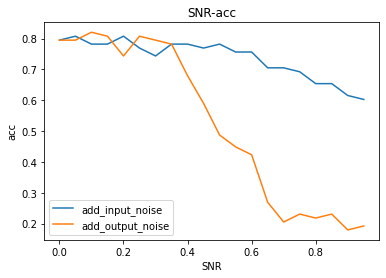

In [278]:
X = [ 0.05*i for i in range(20)]
Y_input = []
Y_output = []
for i in range(20):
    Y_input.append(solve_by_SVM(mode=0,input_SNR=i*0.05)[1])
    Y_output.append(solve_by_SVM(mode=0,output_SNR=i*0.05)[1])

plt.plot(X,Y_input,label = 'add_input_noise')
plt.plot(X,Y_output,label = 'add_output_noise')
plt.title("SNR-acc") 
plt.xlabel("SNR")
plt.ylabel("acc")
plt.legend(loc = 'best')
plt.show()

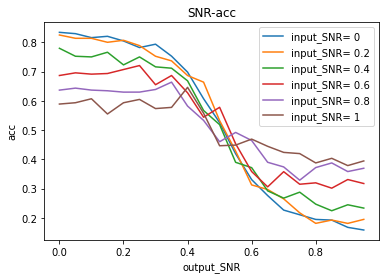

In [280]:
X = [ 0.05*i for i in range(20)]
Y_input0 = []
Y_input20 = []
Y_input40 = []
Y_input60 = []
Y_input80 = []
Y_input100 = []
for i in range(20):
    Y_input0.append(solve_by_SVM(mode=0,input_SNR=0,output_SNR=i*0.05)[0])
    Y_input20.append(solve_by_SVM(mode=0,input_SNR=0.2,output_SNR=i*0.05)[0])
    Y_input40.append(solve_by_SVM(mode=0,input_SNR=0.4,output_SNR=i*0.05)[0])
    Y_input60.append(solve_by_SVM(mode=0,input_SNR=0.6,output_SNR=i*0.05)[0])
    Y_input80.append(solve_by_SVM(mode=0,input_SNR=0.8,output_SNR=i*0.05)[0])
    Y_input100.append(solve_by_SVM(mode=0,input_SNR=1,output_SNR=i*0.05)[0])

plt.plot(X,Y_input0,label = 'input_SNR= 0')
plt.plot(X,Y_input20,label = 'input_SNR= 0.2')
plt.plot(X,Y_input40,label = 'input_SNR= 0.4')
plt.plot(X,Y_input60,label = 'input_SNR= 0.6')
plt.plot(X,Y_input80,label = 'input_SNR= 0.8')
plt.plot(X,Y_input100,label = 'input_SNR= 1')

plt.title("SNR-acc") 
plt.xlabel("output_SNR")
plt.ylabel("acc")
plt.legend(loc = 'best')
plt.show()